# Projeto: Reduzindo os cancelamentos - Telecomunicações

Autora: Georgia A. Cavallaro <br>
Data: 06/03/2025

## 1. Objetivo

Desenvolver um modelo de Machine Learning para a empresa de comunicação *Interconnect*, visando identificar clientes propensos ao cancelamento e oferecer incentivos para retenção.

- **Métrica principal:** AUC-ROC > 0.75
- **Métrica adicional:** Acurácia

**Serviços oferecidos:**

- **Principais:** Telefonia fixa e Internet *(DSL ou fibra óptica)*.
- **Secundários:** Segurança na Internet, suporte técnico, armazenamento na nuvem e streamings *(TV e filmes)*.

**Tabela de conteúdo**
- [1. Objetivo](#1.-Objetivo)  
- [2. Configurando ambiente de trabalho](#2.-Configurando-ambiente-de-trabalho)    
- [3. Importando Dados](#3.-Importando-Dados)    
- [4. Entendendo os dataframes](#4.-Entendendo-os-dataframes)    
- [5. Análise Exploratória](#5-analise-exploratoria)    
- [6. Plano de Resolução da Tarefa](#6-plano-de-resolucao-da-tarefa)    
- [7. Solução da tarefa](#7-solucao-da-tarefa)    
- [8. Testando o modelo com conjunto de dados completo](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)    
- [9. Criando um pipeline para utilização do modelo recomendado](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)    
- [10. Conclusão](#10-conclusao)    
  
<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 2. Configurando ambiente de trabalho

**Tabela de conteúdo**
- [2.1 Importando bibliotecas](#2.1-Importando-bibliotecas)    
- [2.2 Suprimindo avisos desnecessários](#2-2-Suprimindo-avisos-desnecessarios)    
- [2.3 Personalizando opções de visualização de retorno](#2-3-Personalizando-opcoes-de-visualizacao-de-retorno)    
- [2.4 Banco de Funções úteis](#2-4-Banco-de-Funcoes-uteis)

[Voltar ao topo ⬆](#1-objetivo)

### 2.1 Importando bibliotecas

In [ ]:
import timeit
import warnings
import zipfile

import pandas as pd
import seaborn as sns
import numpy as np

from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

[Item anterior ⬆](#2.-Configurando-ambiente-de-trabalho)
<a id="2-2-suprimindo-avisos-desnecessarios"></a>  
### 2.2 Suprimindo avisos desnecessários

In [ ]:
pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore", category=FutureWarning)

[Item anterior ⬆](#2.-Configurando-ambiente-de-trabalho)
<a id="2-3-personalizando-opcoes-de-visualizacao-de-retorno"></a>
### 2.3 Personalizando opções de visualização de retorno

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

[Item anterior ⬆](#2.-Configurando-ambiente-de-trabalho)
<a id="2-4-banco-de-funcoes-uteis"></a>  
### 2.4 Banco de Funções úteis

Todas as funções utilizadas neste caderno são armazenadas aqui.

**Tabela de conteúdo:**
- [2.4.1 Função para exploração estrutural de pastas de dados](#2-4-1-funcao-para-exploracao-estrutural-de-pastas-de-dados)    
- [2.4.2 Função para plotagem de histogramas de dados temporais](#2-4-2-funcao-para-plotagem-de-histogramas-de-dados-temporais)    
- [2.4.3 Função para criação de gráficos em grid com o mesmo objetivo em comum](#2-4-3-funcao-para-criacao-de-graficos-em-grid-com-o-mesmo-objetivo-em-comum)    
- [2.4.4 Função para realizar Validação Cruzada em modelos](#2-4-4-funcao-para-realizar-validacao-cruzada-em-modelos)    

[Item anterior ⬆](#2.-Configurando-ambiente-de-trabalho)

<a id="2-4-1-funcao-para-exploracao-estrutural-de-pastas-de-dados"></a>  
#### 2.4.1 Função para exploração estrutural de pastas de dados

Esta função ajuda a entender a localização dos arquivos de interesse sem necessariamente precisar visualizar ou mesmo descompactar a pasta com os dados.

In [ ]:
def show_structure(structure, level=0):
    indent = " " * 4 * level
    for key in sorted(structure):
        print(f"{indent}📂 {key}" if structure[key] else f"{indent}📑 {key}")
        show_structure(structure[key], level + 1)

[Item anterior ⬆](#2-4-Banco-de-Funcoes-uteis)
<a id="2-4-2-funcao-para-plotagem-de-histogramas-de-dados-temporais"></a>  
#### 2.4.2 Função para plotagem de histogramas de dados temporais

In [ ]:
def plot_date_histogram(
    df,
    title="Distribuição de Churns ao Longo do Tempo",
    column="BeginDate",
    bins=30,
    xlabel="Data de Início do Contrato",
    ylabel="Número de Cancelamentos",
):
    """
    Plota um histograma com KDE de datas de início de contrato para clientes que cancelaram.

    Parâmetros:
    df (pandas.DataFrame): DataFrame contendo os dados a serem analisados
    title (str): Título do gráfico
    column (str): Coluna a ser utilizada pelo eixo x
    bins (int): Número de intervalos para o histograma
    xlabel (str): Legenda do eixo x
    ylabel (str): Legenda do eixo y
    title (str): Título do gráfico
    """

    sns.histplot(
        data=df,
        x=column,
        bins=bins,
        edgecolor="black",
        alpha=0.3,
        kde=True,
        stat="count",
    )

    plt.title(title, fontsize=14, pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt

[Item anterior ⬆](#2-4-Banco-de-Funcoes-uteis)
<a id="2-4-3-funcao-para-criacao-de-graficos-em-grid-com-o-mesmo-objetivo-em-comum"></a>  
#### 2.4.3 Função para criação de gráficos em grid com o mesmo objetivo em comum

In [ ]:
def target_tax_barplot(df, column, target="Churn", ax=None):
    churns = df.groupby([column, target]).size().unstack(fill_value=0)
    churns.columns = ["0", "1"]
    churn_tax = churns.apply(lambda x: x["1"] / (x["0"] + x["1"]), axis=1).reset_index(
        name="churn_tax"
    )

    sns.barplot(
        data=churn_tax, x=column, y="churn_tax", edgecolor="black", alpha=0.7, ax=ax
    )
    ax.set_title(f"Taxa de {target} para cada valor de {column}")
    ax.set_ylabel("Cancelamentos")

    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10)

[Item anterior ⬆](#2-4-Banco-de-Funcoes-uteis)
<a id="2-4-4-funcao-para-realizar-validacao-cruzada-em-modelos"></a>  
#### 2.4.4 Função para realizar Validação Cruzada em modelos

In [ ]:
def cv_models(model, X, y, n_splits=5, n_jobs=14):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=333)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=n_jobs)
    return cv_scores

[Item anterior ⬆](#2-4-Banco-de-Funcoes-uteis)

## 3. Importando Dados

**Tabela de conteúdo:**
- [3.1 Explorando arquivos](#3.1-Explorando-arquivos)    
- [3.2 Criando DataFrames](#3.2-Criando-DataFrames)  

[Voltar ao topo ⬆](#1-objetivo)

### 3.1 Explorando arquivos

In [ ]:
zip_path = "final_provider.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    file_list = zip_ref.namelist()
    structure = {}
    for file in file_list:
        lots = file.split("/")
        current = structure
        for lot in lots:
            if lot not in current:
                current[lot] = {}
            current = current[lot]

show_structure(structure)

📂 __MACOSX
    📂 final_provider
        📑 ._personal.csv
        📑 ._phone.csv
📂 final_provider
    📑 
    📑 contract.csv
    📑 internet.csv
    📑 personal.csv
    📑 phone.csv


[Item anterior ⬆](#3.-Importando-Dados)

### 3.2 Criando DataFrames

In [ ]:
file_path = "final_provider/"
names = ["contract", "internet", "personal", "phone"]
dfs = {}

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    for name in names:
        with zip_ref.open(file_path + name + ".csv") as file:
            dfs[name] = pd.read_csv(file)

df_contract = dfs["contract"]
df_internet = dfs["internet"]
df_personal = dfs["personal"]
df_phone = dfs["phone"]

[Item anterior ⬆](#3.-Importando-Dados)

## 4. Entendendo os dataframes

**Tabela de conteúdo:**
- [4.1 Primeira análise superficial de todos os dataframes](#4-1-primeira-analise-superficial-de-todos-os-dataframes)    
- [4.2 Criando uma *Master Table*](#4.2-Criando-uma-*Master-Table*)    
- [4.3 Conferindo se há valores nulos ou ausentes](#4-3-conferindo-se-ha-valores-nulos-ou-ausentes)    
- [4.4 Tratando valores ausentes](#4.4-Tratando-valores-ausentes)    
- [4.5 Conferindo tipologia dos dados](#4.5-Conferindo-tipologia-dos-dados)    
- [4.6 Criando coluna-objetivo: *'Churn'*](#4.6-Criando-coluna-objetivo:-*'Churn'*)    
- [4.7 Convertendo as colunas para a tipologia correta](#4.7-Convertendo-as-colunas-para-a-tipologia-correta)    
- [4.8 Ordenando os dados por *'BeginDate'*](#4.8-Ordenando-os-dados-por-*'BeginDate'*)    
- [4.9 Conferindo se será útil manter *'BeginDate'*](#4-9-conferindo-se-sera-util-manter-begindate)    
- [4.10 Criando coluna exclusiva para os anos de início dos contratos](#4-10-criando-coluna-exclusiva-para-os-anos-de-inicio-dos-contratos)    
- [4.11 Conferindo integridade dos dados](#4.11-Conferindo-integridade-dos-dados)    
- [4.12 Tratando os valores nulos de *'TotalCharges'*](#4.12-Tratando-os-valores-nulos-de-*'TotalCharges'*)    
- [4.13 Apagando colunas que não serão utilizadas no processo](#4-13-apagando-colunas-que-nao-serao-utilizadas-no-processo)    

[Voltar ao topo ⬆](#1-objetivo)

<a id="4-1-primeira-analise-superficial-de-todos-os-dataframes"></a>  
### 4.1 Primeira análise superficial de todos os dataframes

Farei uma primeira análise rápida visando identificar como posso unir os diferentes dataframes em um só.

In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Todos os dataframes possuem uma coluna em comum chamada `'customerID'`, com a mesma tipagem, esta será a chave para junção dos dados.

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.2 Criando uma *Master Table*

Utilizarei `merge()` com parâmetro *outer* para garantir que nenhum dado será perdido no processo.

In [ ]:
datas = [df_internet, df_personal, df_phone]
data = df_contract.copy()
for d in datas:
    data = data.merge(d, how="outer", on="customerID")

[Item anterior ⬆](#4.-Entendendo-os-dataframes)
<a id="4-3-conferindo-se-ha-valores-nulos-ou-ausentes"></a>  
### 4.3 Conferindo se há valores nulos ou ausentes

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


As colunas que possuem valores nulos ou ausentes são colunas contendo serviços relacionado a *Internet* e quantificações das *linhas de telefone* que o cliente pode ter, sugerindo que a ausência destes valores está relacionada ao fato do cliente ter um dos serviços principais contratados *(telefonia ou internet)* e não possuir o outro, logo não entrou no dataframe contendo os dados sobre os serviços que não possui em seu *contrato*.

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.4 Tratando valores ausentes

**Tabela de conteúdo:**
- [4.4.1 Verificando como posso preencher os valores ausentes](#4.4.1-Verificando-como-posso-preencher-os-valores-ausentes)    
- [4.4.2 Substituindo os valores ausentes por *'No'*](#4.4.2-Substituindo-os-valores-ausentes-por-*'No'*)    

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

#### 4.4.1 Verificando como posso preencher os valores ausentes

In [ ]:
null_cols = data.columns[data.isnull().sum() > 0]
for col in null_cols:
    print(data[col].value_counts())
    print()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64



Todos os valores ausentes podem ser substituídos por *'No'*, pois realmente representam que o serviço não é prestado para aquele cliente.

[Item anterior ⬆](#4.4-Tratando-valores-ausentes)

#### 4.4.2 Substituindo os valores ausentes por *'No'*

In [ ]:
data.fillna("No", inplace=True)

[Item anterior ⬆](#4.4-Tratando-valores-ausentes)

### 4.5 Conferindo tipologia dos dados

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [ ]:
data.sample(5, random_state=333)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
601,0880-FVFWF,2015-06-01,No,Month-to-month,Yes,Electronic check,86.40,4922.4,Fiber optic,Yes,Yes,No,No,No,No,Male,0,No,No,Yes
6311,8931-GJJIQ,2019-01-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,83.30,803.3,Fiber optic,No,No,No,No,No,Yes,Female,0,No,No,Yes
5229,7359-SSBJK,2014-06-01,2019-10-01 00:00:00,Two year,Yes,Credit card (automatic),70.20,4481,DSL,Yes,Yes,No,Yes,Yes,No,Female,1,No,No,No
5497,7740-BTPUX,2015-07-01,No,Two year,Yes,Electronic check,113.60,6292.7,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Male,1,Yes,No,Yes
631,0927-LCSMG,2019-06-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,74.65,544.55,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No


Há colunas contendo **datas**, que precisam ser convertidas para *datetime*, são elas: `'BeginDate', 'EndDate'`. <br>
Não parece ser útil manter a coluna `'EndDate'` por ser tratar de um dado *pós* objetivo da tarefa, preciso criar uma nova coluna binária contendo os valores *'Churn'*. <br>
A coluna `'TotalCharges'` sugere que seja a soma de todos os pagamentos mensais *(`'MonthlyCharges'`)*, logo, precisa ser convertida para *float*.

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.6 Criando coluna-objetivo: *'Churn'*

A coluna-objetivo será baseada em `'EndDate'`, *'No'* são os contratos ainda ativos no momento de extração dos dados e as *datas* são contratos já cancelados que terão suas características analisadas.

In [ ]:
data["Churn"] = data["EndDate"].apply(lambda x: 0 if x == "No" else 1)

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.7 Convertendo as colunas para a tipologia correta

- `'BeginDate'` para *datetime*;
- `'MonthlyCharges'` para *float*.

In [ ]:
data["BeginDate"] = pd.to_datetime(data["BeginDate"], errors="coerce")
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.8 Ordenando os dados por *'BeginDate'*

Para a análise exploratória dos dados será útil entender a tendência dos acontecimentos e se há algum tipo de sazonalidade.

In [ ]:
data = data.sort_values(by="BeginDate")

[Item anterior ⬆](#4.-Entendendo-os-dataframes)
<a id="4-9-conferindo-se-sera-util-manter-begindate"></a>  
### 4.9 Conferindo se será útil manter *'BeginDate'*

Plotarei um histograma para melhor visualização dos dados.

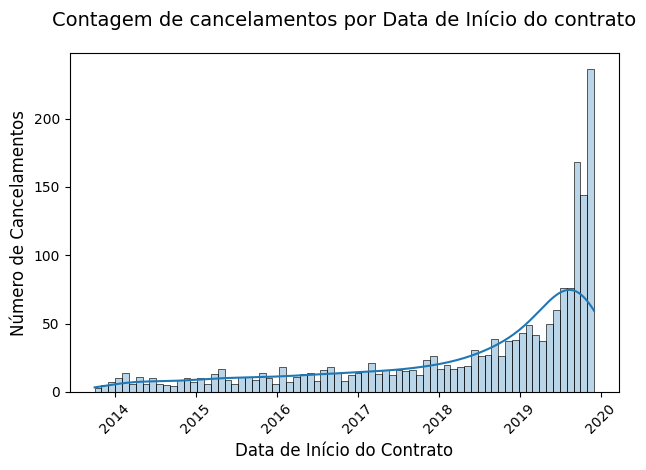

In [ ]:
churned_customers = data[data["Churn"] == 1]
title = "Contagem de cancelamentos por Data de Início do contrato"
bins = 73
plot_date_histogram(churned_customers, title, bins=bins)
plt.show()

Há muitos contratos *antigos* ainda ativos e os maiores cancelamentos são claramente nos contratos mais recentes, a partir de **2018**. Será útil criar features contendo os anos de início dos contratos.

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

<a id="4-10-criando-coluna-exclusiva-para-os-anos-de-inicio-dos-contratos"></a>  
### 4.10 Criando coluna exclusiva para os anos de início dos contratos

In [ ]:
data["BeginYear"] = data["BeginDate"].dt.year.astype(object)

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.11 Conferindo integridade dos dados

Última conferência para garantir que o modelo rodará sem surpresas.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 6055 to 1731
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 non

In [ ]:
data.tail()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn,BeginYear
2250,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes,0,2020
2855,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes,0,2020
3118,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No,0,2020
945,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No,0,2020
1731,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No,No,No,No,No,No,No,Female,0,Yes,Yes,No,0,2020


Agora `'TotalCharges'` possui valores NaN nos contratos mais *recentes*, o que sugere que não tenham pagamentos o suficiente para o sistema calcular um *total*. Serão preenchidos então com *Zero*.

[Item anterior ⬆](#4.-Entendendo-os-dataframes)

### 4.12 Tratando os valores nulos de *'TotalCharges'*

In [ ]:
data["TotalCharges"] = data.apply(
    lambda row: (0 if pd.isna(row["TotalCharges"]) else row["TotalCharges"]),
    axis=1,
)

[Item anterior ⬆](#4.-Entendendo-os-dataframes)
<a id="4-13-apagando-colunas-que-nao-serao-utilizadas-no-processo"></a>  
### 4.13 Apagando colunas que não serão utilizadas no processo

Não precisarei mais das colunas `'customerID'` e `'EndDate'` para análise exploratória nem para o modelo preditivo.

In [ ]:
end_date = data["EndDate"]
customer_id = data["customerID"]

data = data.drop(["EndDate", "customerID"], axis=1)

[Item anterior ⬆](#4.-Entendendo-os-dataframes)
<a id="5-analise-exploratoria"></a>  
## 5. Análise Exploratória

**Tabela de conteúdo:**
- [5.1 Conferindo distribuição e outliers dos dados numéricos](#5-1-conferindo-distribuicao-e-outliers-dos-dados-numericos)    
    - [5.1.1 Ampliando o boxplot de *'MonthlyCharges'*](#5.1.1-Ampliando-o-boxplot-de-*'MonthlyCharges'*)    

[Voltar ao topo ⬆](#1-objetivo)

Antes de adaptar os dados para uso em Machine Learning irei analisar as colunas que mais têm correlação com os cancelamentos.

In [ ]:
columns = [
    "Type",
    "PaperlessBilling",
    "PaymentMethod",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "MultipleLines",
    "BeginYear",
]

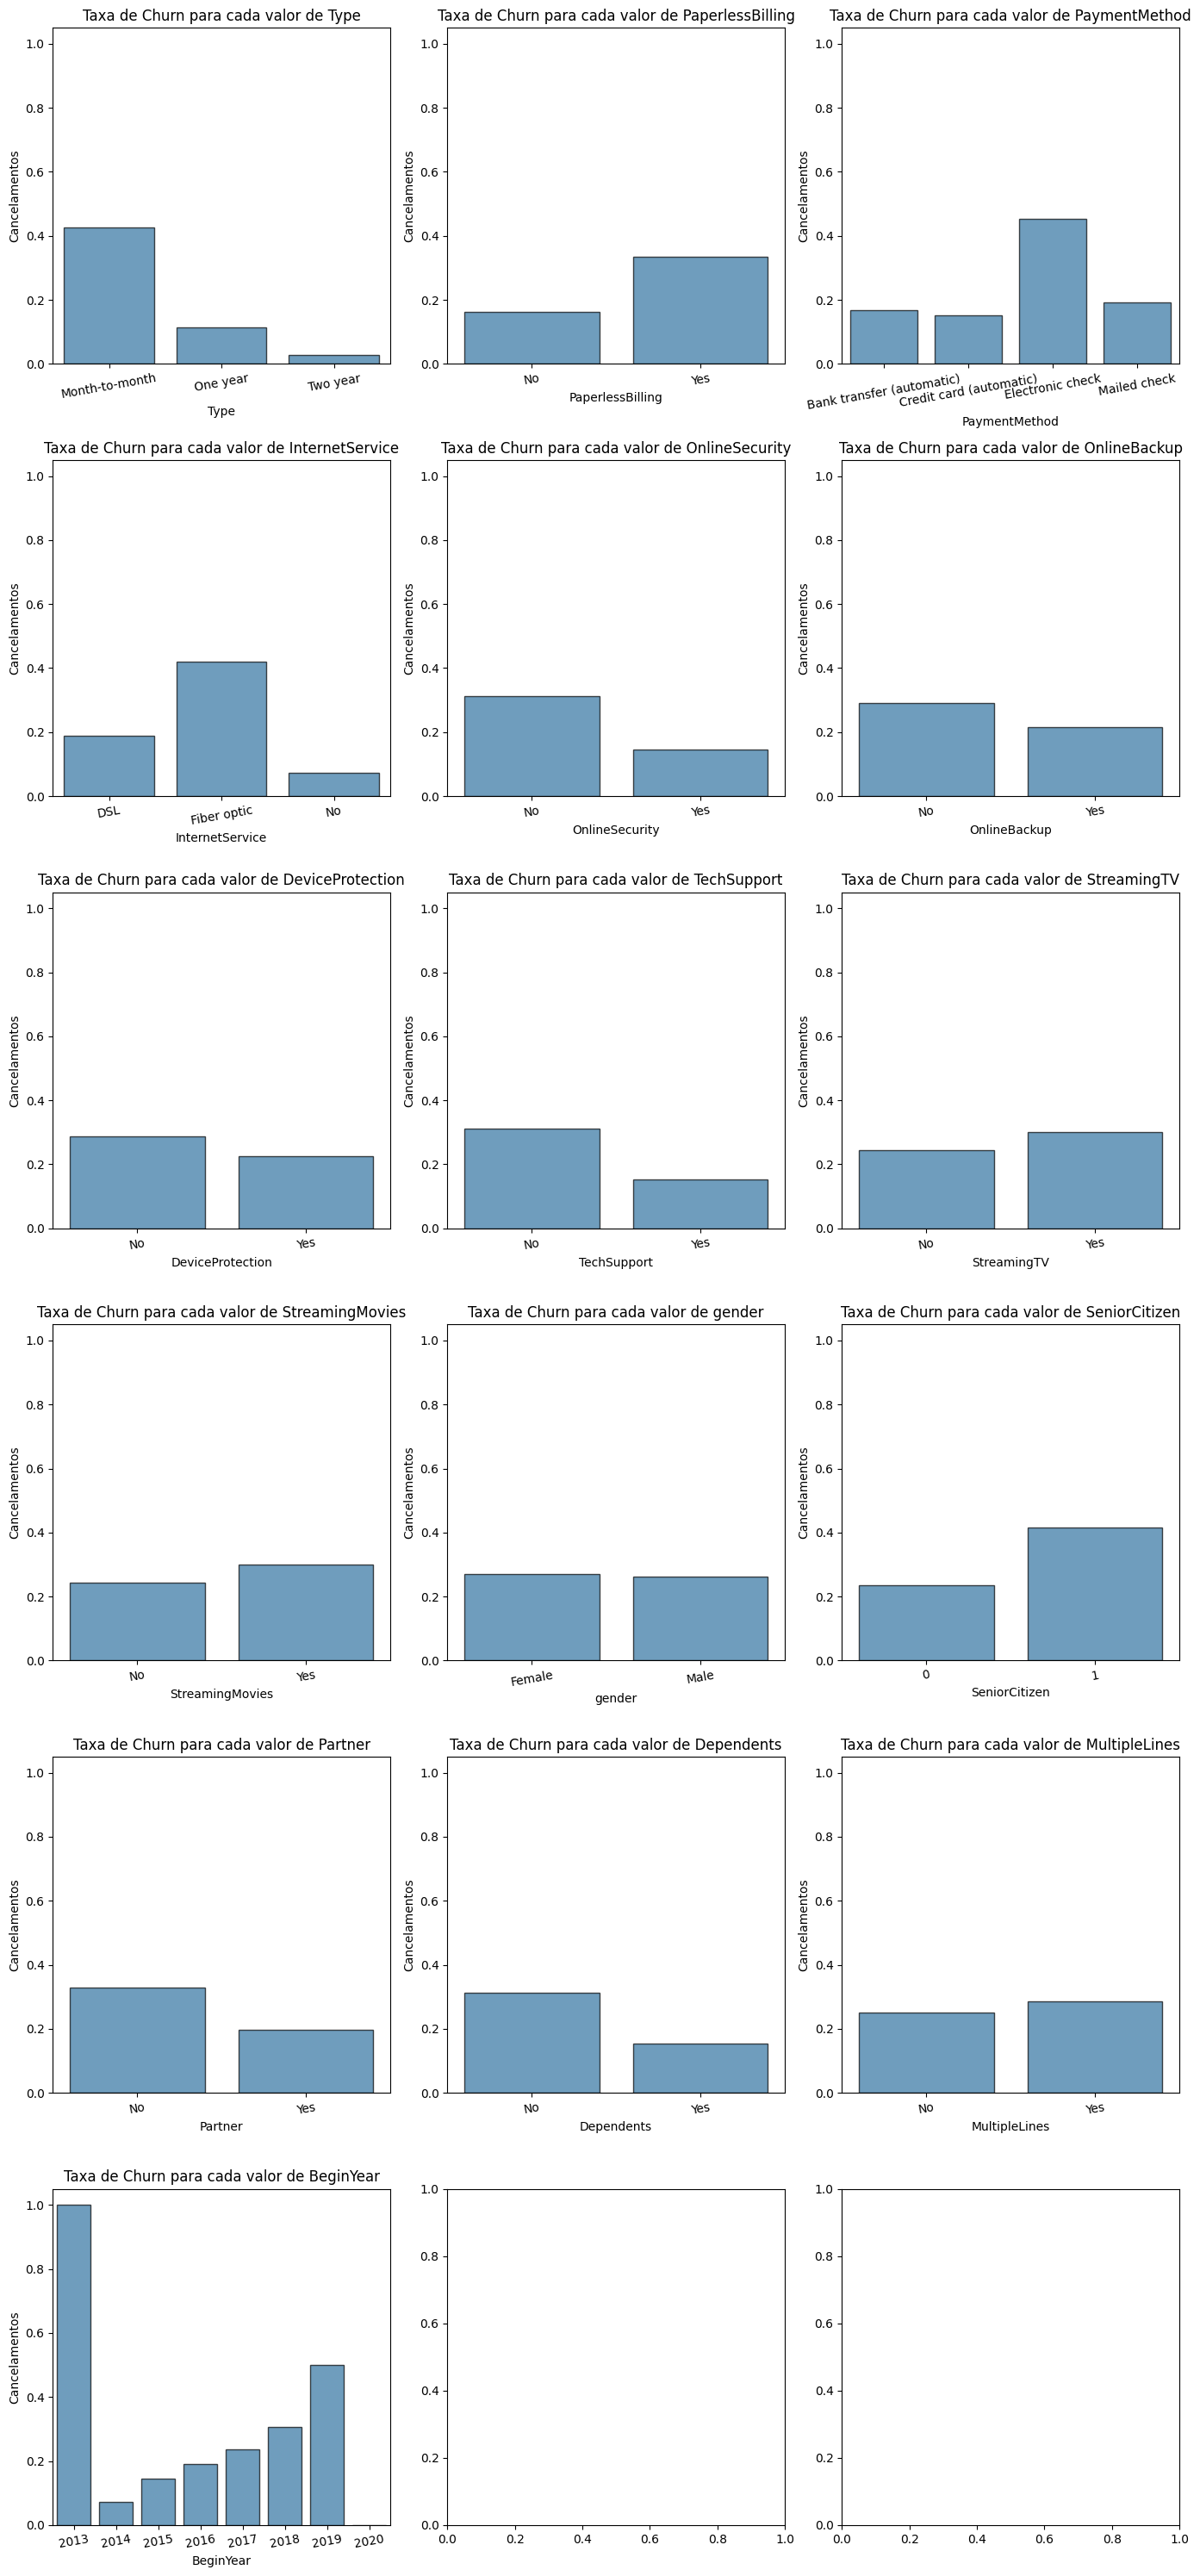

In [ ]:
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 30))
axes = axes.flatten()
y_limit = (0, 1.05)

for i, column in enumerate(columns):
    target_tax_barplot(data, column, "Churn", axes[i])
    axes[i].set_ylim(y_limit)

plt.tight_layout()
plt.show()

Dentre as *features* analisadas as que parecem não ser relevantes ao modelo por haver pouca diferença entre as taxas de *churn* são:

1. **DeviceProtection**: *(cerca de 0.28 para 0.22)*;
2. **StreamingTV**: *(cerca de 0.25 para 0.30)*;
3. **StreamingMovies**: *(cerca de 0.25 para 0.30)*;
4. **Gender**: *(cerca de 0.27 para 0.26)*;
5. **MultipleLines**: *(cerca de 0.25 para 0.29)*.

Serão excluídas na primeira versão do modelo para otimização dos treinamentos, porém as revisitarei para garantir a melhor calibragem possível.

<a id="5-1-conferindo-distribuicao-e-outliers-dos-dados-numericos"></a>  
### 5.1 Conferindo distribuição e outliers dos dados numéricos

O *scaler* a ser utilizado dependerá da distribuição dos dados, do tamanho dos pavios e da presença de *outliers*.

**Tabela de conteúdo:**
- [5.1.1 Ampliando o boxplot de *'MonthlyCharges'*](#5.1.1-Ampliando-o-boxplot-de-*'MonthlyCharges'*)  

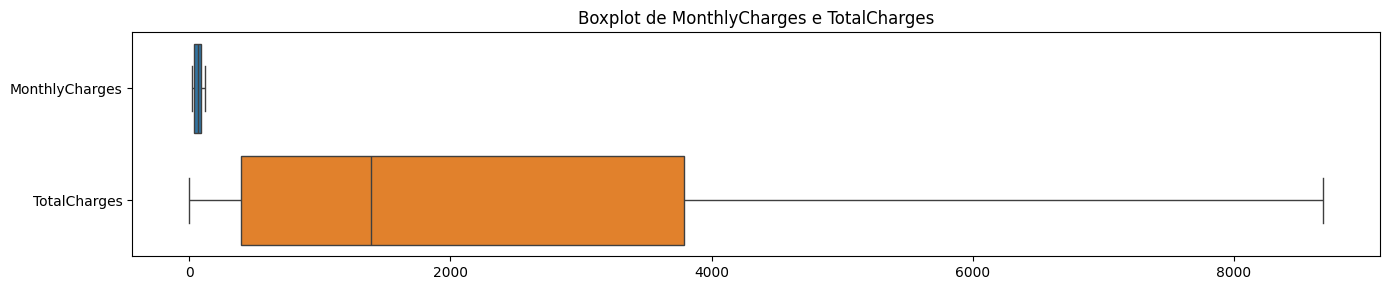

In [ ]:
plt.figure(figsize=(14, 3))
sns.boxplot(data=data[["MonthlyCharges", "TotalCharges"]], orient="h")

plt.title("Boxplot de MonthlyCharges e TotalCharges")
plt.tight_layout()
plt.show()

[Item anterior ⬆](#5-analise-exploratoria)

#### 5.1.1 Ampliando o boxplot de *'MonthlyCharges'*

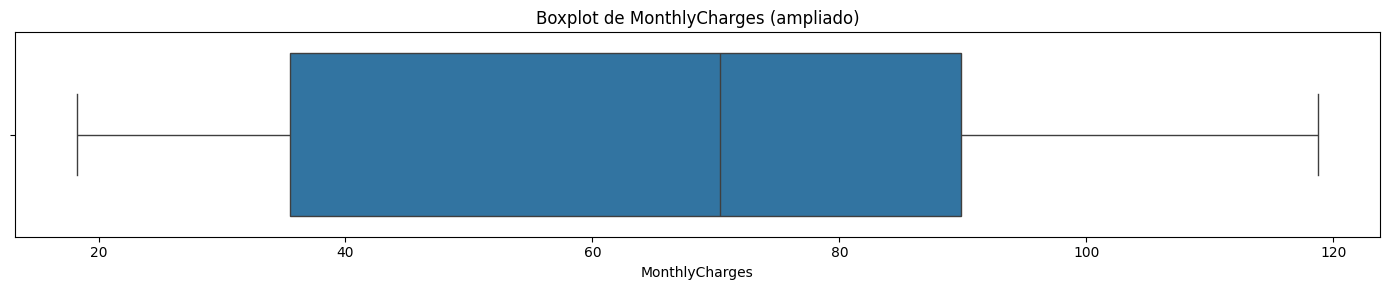

In [ ]:
plt.figure(figsize=(14, 3))
sns.boxplot(data=data["MonthlyCharges"], orient="h")

plt.title("Boxplot de MonthlyCharges (ampliado)")
plt.tight_layout()
plt.show()

Considerando a diferença entre as escalas e o tamanho do pavio de *'TotalCharges'*, usarei o **RobustScaler** para tratamento dos dados com menor distorção.

[Item anterior ⬆](#5-analise-exploratoria)

<a id="6-plano-de-resolucao-da-tarefa"></a>  
## 6. Plano de Resolução da Tarefa

1. Separarei os dados de trabalho *(exclusão das colunas irrelevantes)*;
2. Escalarei os dados numéricos com *RobustScaler* e codificarei as colunas categóricas com *OneHotEncoder*, a coluna `'BeginYear'` será codificada com *OrdinalEncoder*;
3. Treinarei 3 diferentes modelos em busca dos melhores: *tempo de execução* e *taxa AUC-ROC*;
4. Criarei um pipeline de tratamento e execução do modelo para rodar em dados futuros com segurança.

[Voltar ao topo ⬆](#1-objetivo)

<a id="7-solucao-da-tarefa"></a>  
## 7. Solução da tarefa

**Tabela de conteúdo:**
- [7.1 Preparando os dados](#7.1-Preparando-os-dados)    
- [7.2 Treinando modelos](#7.2-Treinando-modelos)    
- [7.3 Rodando modelos no Conjunto de Teste](#7.3-Rodando-modelos-no-Conjunto-de-Teste)    

[Voltar ao topo ⬆](#1-objetivo)

### 7.1 Preparando os dados

**Tabela de conteúdo:**
- [7.1.1 Separando os dados de trabalho](#7.1.1-Separando-os-dados-de-trabalho)    
- [7.1.2 Dividindo conjuntos de Treinamento, Validação e Testes](#7-1-2-dividindo-conjuntos-de-treinamento-validacao-e-testes)    
- [7.1.3 Padronizando as escalas](#7.1.3-Padronizando-as-escalas)    
- [7.1.4 Codificando colunas categóricas Não-Ordinais](#7-1-4-codificando-colunas-categoricas-nao-ordinais)    
- [7.1.5 Codificando *'BeginYear'*](#7.1.5-Codificando-*'BeginYear'*)    

[Item anterior ⬆](#7-solucao-da-tarefa)

#### 7.1.1 Separando os dados de trabalho

In [ ]:
cols = [
    "BeginDate",
    "OnlineBackup",
    "DeviceProtection",
    "StreamingTV",
    "StreamingMovies",
    "gender",
    "MultipleLines",
]

review_later = data[cols]
work_data = data.drop(columns=cols, axis=1)

[Item anterior ⬆](#7.1-Preparando-os-dados)
<a id="7-1-2-dividindo-conjuntos-de-treinamento-validacao-e-testes"></a>
#### 7.1.2 Dividindo conjuntos de Treinamento, Validação e Testes

Será usada a proporção 3:1 na divisão dos dados.

In [ ]:
X = work_data.drop("Churn", axis=1)
y = work_data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=333
)

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(5282, 12)
(1761, 12)

(5282,)
(1761,)


[Item anterior ⬆](#7.1-Preparando-os-dados)

#### 7.1.3 Padronizando as escalas

In [ ]:
num_cols = ["MonthlyCharges", "TotalCharges"]
scaler = RobustScaler().fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

[Item anterior ⬆](#7.1-Preparando-os-dados)
<a id="7-1-4-codificando-colunas-categoricas-nao-ordinais"></a>
#### 7.1.4 Codificando colunas categóricas Não-Ordinais

As colunas categóricas não-ordinais serão codificadas com *OneHotEncoder()*.

In [ ]:
cat_cols = X_train.drop("BeginYear", axis=1).select_dtypes(include="object").columns

encoder = OneHotEncoder(
    handle_unknown="ignore", drop="if_binary", sparse_output=False
).fit(X_train[cat_cols])
col_names = encoder.get_feature_names_out(cat_cols)

X_datas = [X_train, X_test]

for i, df in enumerate(X_datas):
    df_encoded = pd.DataFrame(
        encoder.transform(df[cat_cols]), columns=col_names, index=df.index
    )
    df = df.drop(columns=cat_cols)
    df = pd.concat([df, df_encoded], axis=1)
    X_datas[i] = df

X_train, X_test = X_datas

In [ ]:
print("Conferindo se todos os dataframes de features possuem as mesmas features:")
print(
    f"    ",
    all(X_train.columns) == all((X_test.columns)),
)

Conferindo se todos os dataframes de features possuem as mesmas features:
     True


[Item anterior ⬆](#7.1-Preparando-os-dados)

#### 7.1.5 Codificando *'BeginYear'*

Para `'BeginYear'` será utilizado *OrdinalEncoder()*.

In [ ]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(pd.DataFrame(X_train["BeginYear"]))

X_datas = [X_train, X_test]

for i, df in enumerate(X_datas):
    df_encoded = pd.DataFrame(
        ordinal_encoder.transform(df[["BeginYear"]]),
        columns=["BeginYearEncoded"],
        index=df.index,
    )
    X_datas[i] = pd.concat([df, df_encoded], axis=1)
    X_datas[i] = X_datas[i].drop("BeginYear", axis=1)

X_train, X_test = X_datas

[Item anterior ⬆](#7.1-Preparando-os-dados)

### 7.2 Treinando modelos

1. Procurarei a melhor configuração de modelo com *Validação Cruzada*;
2. Rodarei o modelo no conjunto de testes para conferir *métrica final* e *velocidade de predição*.

**Tabela de conteúdo:**
- [7.2.1 Random Forest Classifier](#7.2.1-Random-Forest-Classifier)
- [7.2.2 K Neighbors Clasifier](#7.2.2-K-Neighbors-Clasifier)
- [7.2.3 CatBoost Classifier](#7.2.3-CatBoost-Classifier)

[Item anterior ⬆](#7-solucao-da-tarefa)

#### 7.2.1 Random Forest Classifier

In [ ]:
auc_train = []
ests = [200, 300]
depths = [5, 7, 10, 12]
ssplit = [2, 5, 7, 10]
cweight = ["balanced", "balanced_subsample"]

for est, depth, split, cw in tqdm(list(product(ests, depths, ssplit, cweight))):
    model = RandomForestClassifier(
        random_state=333,
        n_jobs=-1,
        n_estimators=est,
        max_depth=depth,
        min_samples_split=split,
        class_weight=cw,
    )
    train_score = min(cv_models(model, X_train, y_train))
    auc_train.append(train_score)

100%|██████████| 64/64 [01:15<00:00,  1.18s/it]


In [ ]:
params = pd.DataFrame(
    list(product(ests, depths, ssplit, cweight)),
    columns=["n_estimators", "max_depth", "min_samples_split", "class_weight"],
)
idx = pd.Series(auc_train).idxmax()
print(f"Melhor AUC-ROC no Conjunto de Treino: {auc_train[idx]:.2f}")
print(f" - Ciclo: {idx}")
print()
print(f"Parâmetros:")
print(params.iloc[idx])

Melhor AUC-ROC no Conjunto de Treino: 0.86
 - Ciclo: 23

Parâmetros:
n_estimators                        200
max_depth                            10
min_samples_split                    10
class_weight         balanced_subsample
Name: 23, dtype: object


In [ ]:
rf_model = RandomForestClassifier(
    random_state=333,
    n_jobs=14,
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced_subsample",
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_split=10, n_estimators=200, n_jobs=14,
                       random_state=333)

O modelo *Random Forest Classifier* performou muito bem com o Conjunto de Treino, **AUC-ROC score de 0.86**.

**Hiperparâmetros:**
- `n_estimators` = 200;
- `max_depth` = 10;
- `min_samples_split` = 10;
- `class_weight` = 'balanced_subsample'.

[Item anterior ⬆](#7.2-Treinando-modelos)

#### 7.2.2 K Neighbors Clasifier

In [ ]:
auc_train = []
auc_valid = []
nn = [3, 5, 9, 12, 15, 18, 21, 24, 27, 30, 33, 35, 36, 37, 39, 42, 45, 48]
metrics = ["cityblock", "cosine", "euclidean"]
weights = ["uniform", "distance"]

for n, metric, weight in tqdm(list(product(nn, metrics, weights))):
    model = KNeighborsClassifier(
        n_jobs=14,
        n_neighbors=n,
        metric=metric,
        weights=weight,
    )
    train_score = min(cv_models(model, X_train, y_train))
    auc_train.append(train_score)

100%|██████████| 108/108 [00:18<00:00,  5.92it/s]


In [ ]:
params = pd.DataFrame(
    list(product(nn, metrics, weights)),
    columns=["n_neighbors", "metric", "weights"],
)
idx = pd.Series(auc_train).idxmax()
print(f"Melhor AUC-ROC no Conjunto de Treino: {auc_train[idx]:.2f}")
print(f" - Ciclo: {idx}")
print()
print(f"Parâmetros:")
print(params.iloc[idx])

Melhor AUC-ROC no Conjunto de Treino: 0.83
 - Ciclo: 107

Parâmetros:
n_neighbors           48
metric         euclidean
weights         distance
Name: 107, dtype: object


In [ ]:
knn_model = KNeighborsClassifier(
    n_jobs=-1,
    n_neighbors=48,
    metric="euclidean",
    weights="distance",
)

knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=48,
                     weights='distance')

O modelo *K Neighbors Classifier* teve uma performance ligeiramente inferior com o Conjunto de Treino, **AUC-ROC score de 0.83**.

**Hiperparâmetros:**
- `n_neighbors` = 48;
- `metric` = 'euclidean';
- `weights` = 'distance'.

[Item anterior ⬆](#7.2-Treinando-modelos)

#### 7.2.3 CatBoost Classifier

In [ ]:
cat_model = CatBoostClassifier(
    random_seed=333,
    task_type="GPU",
    verbose=100,
    eval_metric="Logloss",
    auto_class_weights="SqrtBalanced",
)

In [ ]:
auc_train = []

train_score = min(cv_models(cat_model, X_train, y_train, n_jobs=None))
auc_train.append(train_score)

Learning rate set to 0.031142
0:	learn: 0.6727065	total: 127ms	remaining: 2m 7s
100:	learn: 0.4021945	total: 3.75s	remaining: 33.4s
200:	learn: 0.3881067	total: 7.3s	remaining: 29s
300:	learn: 0.3791138	total: 10.8s	remaining: 25.2s
400:	learn: 0.3732251	total: 14.3s	remaining: 21.4s
500:	learn: 0.3704610	total: 17.7s	remaining: 17.7s
600:	learn: 0.3680469	total: 21.2s	remaining: 14.1s
700:	learn: 0.3648192	total: 24.8s	remaining: 10.6s
800:	learn: 0.3624689	total: 28.4s	remaining: 7.06s
900:	learn: 0.3590247	total: 32s	remaining: 3.51s
999:	learn: 0.3561815	total: 35.5s	remaining: 0us
Learning rate set to 0.031142
0:	learn: 0.6735296	total: 42.6ms	remaining: 42.6s
100:	learn: 0.4014006	total: 3.72s	remaining: 33.1s
200:	learn: 0.3862722	total: 7.15s	remaining: 28.4s
300:	learn: 0.3787670	total: 10.7s	remaining: 24.9s
400:	learn: 0.3727875	total: 14.2s	remaining: 21.2s
500:	learn: 0.3675015	total: 17.7s	remaining: 17.6s
600:	learn: 0.3641648	total: 21.2s	remaining: 14.1s
700:	learn: 0.

In [ ]:
print(f"Melhor AUC-ROC no Conjunto de Treino: {auc_train[0]:.2f}")

Melhor AUC-ROC no Conjunto de Treino: 0.87


In [ ]:
cat_model.fit(
    X_train,
    y_train,
    use_best_model=True,
    eval_set=(X_test, y_test),
    verbose=100,
    early_stopping_rounds=50,
)

Learning rate set to 0.061814
0:	learn: 0.6536066	test: 0.6560213	best: 0.6560213 (0)	total: 41.6ms	remaining: 41.6s
100:	learn: 0.3897931	test: 0.4152857	best: 0.4152569 (97)	total: 3.65s	remaining: 32.5s
200:	learn: 0.3686355	test: 0.4069563	best: 0.4069563 (200)	total: 7.37s	remaining: 29.3s
300:	learn: 0.3563727	test: 0.4051372	best: 0.4047115 (294)	total: 11s	remaining: 25.6s
bestTest = 0.4047115493
bestIteration = 294
Shrink model to first 295 iterations.


O modelo *Cat Boost Classifier* teve performance significativamente superior com o Conjunto de Treino, **AUC-ROC score de 0.87**.

**Hiperparâmetros listados na tabela abaixo.** 🔽

In [ ]:
cat_params = pd.DataFrame(
    list(cat_model.get_all_params().items()), columns=["Parameter", "Value"]
)
cat_params

,Parameter,Value
0,nan_mode,Min
1,gpu_ram_part,0.95
2,eval_metric,Logloss
3,iterations,1000
4,fold_permutation_block,64
5,leaf_estimation_method,Newton
6,observations_to_bootstrap,TestOnly
7,od_pval,0
8,random_score_type,NormalWithModelSizeDecrease
9,grow_policy,SymmetricTree


[Item anterior ⬆](#7.2-Treinando-modelos)

### 7.3 Rodando modelos no Conjunto de Teste

Neste momento avaliarei *performance* vs *tempo de predição* de cada um modelos para o Conjunto de Teste.

In [ ]:
models = [rf_model, knn_model, cat_model]
names = ["RandomForestClassifier", "KNeighborsClassifier", "CatBoostClassifier"]

for name, model in zip(names, models):
    avg_time = timeit.timeit(lambda: model.predict(X_test), number=10) / 10
    preds = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, preds)

    print(f"Modelo: {name}")
    print(f"Tempo médio de previsão do modelo: {avg_time:.6f} segundos")
    print(f"AUC-ROC score no Conjunto de Testes: {auc_roc:.2f}")
    print()

Modelo: RandomForestClassifier
Tempo médio de previsão do modelo: 0.053288 segundos
AUC-ROC score no Conjunto de Testes: 0.87

Modelo: KNeighborsClassifier
Tempo médio de previsão do modelo: 0.065324 segundos
AUC-ROC score no Conjunto de Testes: 0.84

Modelo: CatBoostClassifier
Tempo médio de previsão do modelo: 0.002638 segundos
AUC-ROC score no Conjunto de Testes: 0.88



**CatBoostClassifier** superou todos os modelos, tanto em *tempo de execução* quanto em *AUC-ROC score*!

**Avaliação final:**
- *CatBoost Classifier*: Score **0.88** em *0.003* segundos;
- *Random Forest Classifier*: Score **0.87** em *0.056* segundos;
- *K Neighbors Classifier*: Score **0.84** em *0.065* segundos.

[Item anterior ⬆](#7-solucao-da-tarefa)

## 8. Testando o modelo com conjunto de dados completo

Irei utilizar o melhor modelo *(CatBoostClassifier)* para testar possíveis melhorias com as colunas retiradas no começo do estudo. <br>
Será aplicado o mesmo preprocessamento dos dados utilizado anteriormente.

**Tabela de conteúdo:**
- [8.1 Retirando coluna *'BeginDate'*](#8.1-Retirando-coluna-*'BeginDate'*)
- [8.2 Dividindo conjuntos de Treinamento e Teste](#8.2-Dividindo-conjuntos-de-Treinamento-e-Teste)
- [8.3 Padronizando as escalas](#8.3-Padronizando-as-escalas)
- [8.4 Codificando colunas categóricas Não-Ordinais](#8-4-codificando-colunas-categoricas-nao-ordinais)    
- [8.5 Codificando *'BeginYear'*](#8.5-Codificando-*'BeginYear'*)
- [8.6 Treinando modelo *CatBoost Classifier*](#8.6-Treinando-modelo-*CatBoost-Classifier*)
- [8.7 Prosseguindo o treinamento com *'eval_set'*](#8.7-Prosseguindo-o-treinamento-com-*'eval_set'*)
- [8.8 Rodando o modelo no Conjunto de Testes](#8.8-Rodando-o-modelo-no-Conjunto-de-Testes)

[Voltar ao topo ⬆](#1-objetivo)

### 8.1 Retirando coluna *'BeginDate'*

Esta coluna ainda será retirada pois os dados relevantes dela já estão em *'BeginYear'*.

In [ ]:
data2 = data.drop("BeginDate", axis=1)

[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.2 Dividindo conjuntos de Treinamento e Teste

In [ ]:
X2 = data2.drop("Churn", axis=1)
y2 = data2["Churn"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.25, random_state=333
)

print(X_train2.shape)
print(X_test2.shape)
print()
print(y_train2.shape)
print(y_test2.shape)

(5282, 18)
(1761, 18)

(5282,)
(1761,)


[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.3 Padronizando as escalas

In [ ]:
num_cols = ["MonthlyCharges", "TotalCharges"]
scaler = RobustScaler().fit(X_train2[num_cols])

X_train2[num_cols] = scaler.transform(X_train2[num_cols])
X_test2[num_cols] = scaler.transform(X_test2[num_cols])

[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)
<a id="8-4-codificando-colunas-categoricas-nao-ordinais"></a>
### 8.4 Codificando colunas categóricas Não-Ordinais

In [ ]:
cat_cols = X_train2.drop("BeginYear", axis=1).select_dtypes(include="object").columns

encoder = OneHotEncoder(
    handle_unknown="ignore", drop="if_binary", sparse_output=False
).fit(X_train2[cat_cols])
col_names = encoder.get_feature_names_out(cat_cols)

X_datas2 = [X_train2, X_test2]

for i, df in enumerate(X_datas2):
    df_encoded = pd.DataFrame(
        encoder.transform(df[cat_cols]), columns=col_names, index=df.index
    )
    df = df.drop(columns=cat_cols)
    df = pd.concat([df, df_encoded], axis=1)
    X_datas2[i] = df

X_train2, X_test2 = X_datas2

[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.5 Codificando *'BeginYear'*

In [ ]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(pd.DataFrame(X_train2["BeginYear"]))

X_datas2 = [X_train2, X_test2]

for i, df in enumerate(X_datas2):
    df_encoded = pd.DataFrame(
        ordinal_encoder.transform(df[["BeginYear"]]),
        columns=["BeginYearEncoded"],
        index=df.index,
    )
    X_datas2[i] = pd.concat([df, df_encoded], axis=1)
    X_datas2[i] = X_datas2[i].drop("BeginYear", axis=1)

X_train2, X_test2 = X_datas2

[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.6 Treinando modelo *CatBoost Classifier*

In [ ]:
cat_model2 = CatBoostClassifier(
    random_seed=333,
    task_type="GPU",
    verbose=100,
    eval_metric="Logloss",
    auto_class_weights="SqrtBalanced",
)

In [ ]:
auc_train = []

train_score = min(cv_models(cat_model2, X_train2, y_train2, n_jobs=None))
auc_train.append(train_score)

Learning rate set to 0.031142
0:	learn: 0.6727065	total: 38.1ms	remaining: 38.1s
100:	learn: 0.3996977	total: 3.63s	remaining: 32.3s
200:	learn: 0.3829795	total: 7.25s	remaining: 28.8s
300:	learn: 0.3733618	total: 10.8s	remaining: 25.1s
400:	learn: 0.3636873	total: 14.5s	remaining: 21.6s
500:	learn: 0.3585260	total: 18.1s	remaining: 18s
600:	learn: 0.3543882	total: 21.6s	remaining: 14.4s
700:	learn: 0.3503011	total: 25.2s	remaining: 10.8s
800:	learn: 0.3478171	total: 28.8s	remaining: 7.16s
900:	learn: 0.3451730	total: 32.3s	remaining: 3.55s
999:	learn: 0.3418175	total: 35.9s	remaining: 0us
Learning rate set to 0.031142
0:	learn: 0.6734421	total: 35ms	remaining: 35s
100:	learn: 0.3988499	total: 3.55s	remaining: 31.6s
200:	learn: 0.3822782	total: 7.26s	remaining: 28.9s
300:	learn: 0.3745471	total: 11s	remaining: 25.5s
400:	learn: 0.3658250	total: 14.5s	remaining: 21.7s
500:	learn: 0.3585816	total: 18s	remaining: 18s
600:	learn: 0.3533516	total: 21.5s	remaining: 14.3s
700:	learn: 0.347098

In [ ]:
print(f"Melhor AUC-ROC no Conjunto de Treino: {auc_train[0]:.2f}")

Melhor AUC-ROC no Conjunto de Treino: 0.87


O modelo *não apresentou melhora* no conjunto de treinamento com os parâmetros que haviam sido retirados, vou continuar com o treinamento utilizando *eval_set* a procura de melhora na performance com os novos dados.

[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.7 Prosseguindo o treinamento com *'eval_set'*

In [ ]:
cat_model2.fit(
    X_train2,
    y_train2,
    use_best_model=True,
    eval_set=(X_test2, y_test2),
    verbose=100,
    early_stopping_rounds=50,
)

Learning rate set to 0.061814
0:	learn: 0.6536066	test: 0.6560213	best: 0.6560213 (0)	total: 38.4ms	remaining: 38.4s
100:	learn: 0.3857279	test: 0.4139128	best: 0.4139128 (100)	total: 3.67s	remaining: 32.7s
200:	learn: 0.3627532	test: 0.4058648	best: 0.4058648 (200)	total: 7.21s	remaining: 28.7s
300:	learn: 0.3460195	test: 0.4029633	best: 0.4029633 (300)	total: 10.8s	remaining: 25s
bestTest = 0.4024306799
bestIteration = 346
Shrink model to first 347 iterations.


[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

### 8.8 Rodando o modelo no Conjunto de Testes

In [ ]:
avg_time = timeit.timeit(lambda: cat_model2.predict(X_test2), number=10) / 10
preds = cat_model2.predict_proba(X_test2)[:, 1]
auc_roc = roc_auc_score(y_test2, preds)

print(f"Modelo: CatBoost Classifier - com conjunto completo de features")
print(f"Tempo médio de previsão do modelo: {avg_time:.6f} segundos")
print(f"AUC-ROC score no Conjunto de Testes: {auc_roc:.2f}")

Modelo: CatBoost Classifier - com conjunto completo de features
Tempo médio de previsão do modelo: 0.002445 segundos
AUC-ROC score no Conjunto de Testes: 0.89


**No conjunto de testes** o modelo com o conjunto completo de features superou o modelo com as features filtradas, tanto em *tempo de execução* quanto em *AUC-ROC score*!

**Avaliação final - CatBoost Classifier:**
- *Com features filtradas*: Score **0.88** em *0.003* segundos;
- *Com conjunto de features completo*: Score **0.89** em *0.002* segundos.

Considerando que uma das preocupações em filtrar o conjunto de features era de deixar a execução do modelo *mais leve e rápida*, não faz mais sentido a exclusão de colunas, o modelo performa melhor com todas as features.

**Hiperparâmetros listados na tabela abaixo.** 🔽

In [ ]:
cat_params = pd.DataFrame(
    list(cat_model2.get_all_params().items()), columns=["Parameter", "Value"]
)
cat_params

,Parameter,Value
0,nan_mode,Min
1,gpu_ram_part,0.95
2,eval_metric,Logloss
3,iterations,1000
4,fold_permutation_block,64
5,leaf_estimation_method,Newton
6,observations_to_bootstrap,TestOnly
7,od_pval,0
8,random_score_type,NormalWithModelSizeDecrease
9,grow_policy,SymmetricTree


[Item anterior ⬆](#8.-Testando-o-modelo-com-conjunto-de-dados-completo)

<a id="9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado"></a>
## 9. Criando um pipeline para utilização do modelo recomendado

Criarei uma *pipeline* simples baseada em **funções**, replicando todo o processo de tratamento de dados e treinamento de modelo executado neste caderno, para uso em arquivos *.csv*.

**Tabela de conteúdo:**
- [9.1 Função para carregar e unir os dados](#9-1-funcao-para-carregar-e-unir-os-dados)
- [9.2 Função para tratamento inicial dos dados](#9-2-funcao-para-tratamento-inicial-dos-dados)
- [9.3 Função para Criação de Pipeline](#9-3-funcao-para-criacao-de-pipeline)
- [9.4 Função para novos treinamentos do modelo](#9-4-funcao-para-novos-treinamentos-do-modelo)
- [9.5 Função para fazer predições a partir dos dados em .csv](#9-5-funcao-para-fazer-predicoes-a-partir-dos-dados-em-csv)

[Voltar ao topo ⬆](#1-objetivo)

<a id="9-1-funcao-para-carregar-e-unir-os-dados"></a>
### 9.1 Função para carregar e unir os dados

In [ ]:
def load_join_data(contract_path, internet_path, personal_path, phone_path):
    """
    Carrega e une os dados dos diferentes arquivos
    """
    df_contract = pd.read_csv(contract_path)
    df_internet = pd.read_csv(internet_path)
    df_personal = pd.read_csv(personal_path)
    df_phone = pd.read_csv(phone_path)

    data = df_contract.copy()
    for df in [df_internet, df_personal, df_phone]:
        data = data.merge(df, how="outer", on="customerID")

    data.fillna("No", inplace=True)

    return data

[Item anterior ⬆](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)
<a id="9-2-funcao-para-tratamento-inicial-dos-dados"></a>
### 9.2 Função para tratamento inicial dos dados

In [ ]:
def data_prep(data, train_mode=True):
    """
    Prepara os dados para treino ou predição
    """

    if train_mode and "EndDate" in data.columns:
        data["Churn"] = data["EndDate"].apply(lambda x: 0 if x == "No" else 1)

    customer_ids = data["customerID"].copy() if "customerID" in data.columns else None

    if "BeginDate" in data.columns:
        data["BeginDate"] = pd.to_datetime(data["BeginDate"], errors="coerce")
        data["BeginYear"] = data["BeginDate"].dt.year.astype(object)

    if "TotalCharges" in data.columns:
        data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

        if "MonthlyCharges" in data.columns:
            data["TotalCharges"] = data.apply(
                lambda row: (
                    0 if pd.isna(row["TotalCharges"]) else row["TotalCharges"]
                ),
                axis=1,
            )

    return data, customer_ids

[Item anterior ⬆](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)
<a id="9-3-funcao-para-criacao-de-pipeline"></a>
### 9.3 Função para Criação de Pipeline

In [ ]:
def pipeline_create():
    """
    Cria um pipeline para o modelo de churn
    """
    num_cols = ["MonthlyCharges", "TotalCharges"]

    year_cols = ["BeginYear"]

    cat_cols = [
        "Type",
        "InternetService",
        "PaymentMethod",
        "Partner",
        "Dependents",
        "PhoneService",
        "PaperlessBilling",
        "SeniorCitizen",
        "TechSupport",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "StreamingTV",
        "StreamingMovies",
        "gender",
        "MultipleLines",
    ]

    num_processor = Pipeline([("scaler", RobustScaler())])

    year_processor = Pipeline([("ordinal", OrdinalEncoder())])

    cat_processor = Pipeline(
        [
            (
                "onehot",
                OneHotEncoder(
                    handle_unknown="ignore", drop="if_binary", sparse_output=False
                ),
            )
        ]
    )

    col_transformer = ColumnTransformer(
        transformers=[
            ("num", num_processor, num_cols),
            ("cat", cat_processor, cat_cols),
            ("year", year_processor, year_cols),
        ],
        remainder="drop",
    )

    pipeline = Pipeline(
        [
            ("col_transformer", col_transformer),
            (
                "model",
                CatBoostClassifier(
                    verbose=100,
                    eval_metric="Logloss",
                    random_seed=333,
                    auto_class_weights="SqrtBalanced",
                ),
            ),
        ]
    )

    return pipeline

[Item anterior ⬆](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)
<a id="9-4-funcao-para-novos-treinamentos-do-modelo"></a>
### 9.4 Função para novos treinamentos do modelo

In [ ]:
def treinar_modelo(pipeline, X_train, y_train, X_valid=None, y_valid=None):
    """
    Treina o modelo com os dados fornecidos
    """
    fit_params = {}

    if X_valid is not None and y_valid is not None:
        fit_params = {
            "model__eval_set": [(X_valid, y_valid)],
            "model__early_stopping_rounds": 50,
        }

    pipeline.fit(X_train, y_train, **fit_params)

    return pipeline

[Item anterior ⬆](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)
<a id="9-5-funcao-para-fazer-predicoes-a-partir-dos-dados-em-csv"></a>
### 9.5 Função para fazer predições a partir dos dados em .csv

In [ ]:
def predict(model_path, contract_path, internet_path, personal_path, phone_path):
    """
    Faz predições com novos dados usando um modelo salvo
    """
    print("Carregando modelo...")

    try:
        pipeline = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Modelo não encontrado em {model_path}")
        return None

    try:
        data = load_join_data(contract_path, internet_path, personal_path, phone_path)
    except FileNotFoundError:
        print("Arquivos de dados não encontrados. Verifique os caminhos.")
        return None

    prep_data, customer_ids = data_prep(data, train_mode=False)

    predicts = pipeline.predict(prep_data)
    probas = pipeline.predict_proba(prep_data)[:, 1]

    results = pd.DataFrame(
        {
            "customerID": customer_ids,
            "churn_preds": predicts,
            "churn_probas": probas,
        }
    )

    print(f"Predições realizadas para {len(results)} clientes.")

    return results

[Item anterior ⬆](#9-criando-um-pipeline-para-utilizacao-do-modelo-recomendado)
<a id="10-conclusao"></a>
## 10. Conclusão

**Tabela de conteúdo:**
- [10.1 Resultados Obtidos](#10.1-Resultados-Obtidos)
- [10.2 Insights Relevantes](#10.2-Insights-Relevantes)
- [10.3 Impacto e Aplicabilidade](#10.3-Impacto-e-Aplicabilidade)
- [10.4 Modelo recomendado:](#10.4-Modelo-recomendado:)

[Voltar ao topo ⬆](#1-objetivo)

### 10.1 Resultados Obtidos

**O objetivo do projeto foi alcançado:** o modelo de Machine Learning desenvolvido consegue prever clientes propensos ao cancelamento.

O modelo *CatBoost Classifier* apresentou o melhor desempenho, alcançando um **AUC-ROC de 0.87** no conjunto de treino e **0.89** no conjunto de teste.

O *Random Forest Classifier* também teve bom desempenho, com **AUC-ROC de 0.86** no treino e **0.87** no teste.

O *K Neighbors Classifier* obteve um **AUC-ROC de 0.84** em ambos os conjuntos, sendo o modelo menos eficiente.

Além disso, desenvolvi uma **Pipeline** para automatizar o processo de tratamento, treinamento e predição de novos dados. A pipeline consiste em:

- Função para carregar e unir os dados;
- Função para tratamento inicial dos dados;
- Função para criação do pipeline de Machine Learning;
- Função para realizar novos treinamentos do modelo;
- Função para fazer predições a partir de dados em .csv.

Essa estrutura garante a reprodutibilidade e a escalabilidade do processo, tornando a aplicação do modelo em novos dados mais eficiente.

[Item anterior ⬆](#10-conclusao)

### 10.2 Insights Relevantes

O cancelamento de clientes *("Churn")* está fortemente relacionado a fatores como:

- **Tempo de contrato:** contratos mais recentes têm maior taxa de cancelamento;
- **Tempo de renovação do contrato:** contratos com períodos de renovação mais curtos (como o *Mensal*), têm maior taxa de cancelamento;
- Contratos com **cobranças eletrônicas porém** ***não automáticas*** também são mais propensos ao cancelamento;
- Dos contratos com serviço de internet os de **Fibra Ótica** são os mais cancelados.

[Item anterior ⬆](#10-conclusao)

### 10.3 Impacto e Aplicabilidade

O modelo pode ser aplicado em campanhas de retenção para clientes com maior risco de cancelamento. <br>
A empresa pode criar incentivos direcionados *(descontos, serviços gratuitos por tempo limitado, suporte diferenciado)* para os perfis de clientes mais propensos a cancelar. <br>
Possibilidade de otimizar os pacotes de serviço para reduzir cancelamentos, como oferecer planos de menor custo para clientes de alto risco.

[Item anterior ⬆](#10-conclusao)

### 10.4 Modelo recomendado:

O modelo mais recomendado para uso *(e utilizado no pipeline proposto)* é o **CatBoostClassifier** treinado com os Hiperparâmetros da tabela a seguir *(variável cat_params)*.

In [ ]:
cat_params

,Parameter,Value
0,nan_mode,Min
1,gpu_ram_part,0.95
2,eval_metric,Logloss
3,iterations,1000
4,fold_permutation_block,64
5,leaf_estimation_method,Newton
6,observations_to_bootstrap,TestOnly
7,od_pval,0
8,random_score_type,NormalWithModelSizeDecrease
9,grow_policy,SymmetricTree


[Voltar ao topo ⬆](#1-objetivo)